# Schey JAMS Zebrafish lens with DIA

## Bruker PASEF DIA

## edgeR statistical testing notebook (no TMM normalization)

### prepared by Phil Wilmarth, PSR Core OHSU

#### Jun 13, 2025

---

- [Overview](#overview)
- [Read in the data](#load_data) 
- [Clustering and Normalization](#TMM)
- [Cortex versus Nucleus region](#CN)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

Zebrafish lens from https://pubs.acs.org/doi/10.1021/jasms.5c00087 paper. Schey lab. Cortex versus nucleus. 3 replicates each. DIA using Bruker PASEF platform.

> Zelle, S.R., McDonald, W.H., Rose, K.L., Mchaourab, H.S. and Schey, K.L., 2025. Data-Independent Acquisition Parallel Accumulation–Serial Fragmentation (diaPASEF) Analysis of the Separated Zebrafish Lens Improves Identifications. Journal of the American Society for Mass Spectrometry.

---

#### Sample Comparisons:

Compare cortex to nucleus using the Bioconductor package edgeR (*Robinson 2010*) to perform the statistical comparison using the exact test. TMM normalization will not be used, just the library size matching (intensity grand total per sample matching).

### References

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE, table = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    if(table == TRUE) {
        cat("\nLibrary size factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    }
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    if(table == TRUE) {
        cat("\nTrimmed mean of M-values (TMM) factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    }
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    if(table == TRUE) {
        cat("\nCombined (lib size and TMM) normalization factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))
    }

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============ runs an edgeR exact pairwise test ========================
pairwise_test <- function(delist, pair, p.value) {
    # runs an edgeR exact test and returns results
    et <- exactTest(delist, pair = pair)
    tt <- topTags(et, n = Inf, sort.by = "none")
    
    # print top tags
    cat("\n")
    print(topTags(et)$table, digits = 4)
    cat("\n")
    
    # count candidates
    print(summary(decideTests(et, p.value = p.value)))

    # see candidates on an MA plot
    plotMD(et, p.value = p.value)
    abline(h = c(-1, 1), col = "black")
    
    # check the p-value distribution
    pval <- ggplot(tt$table, aes(PValue)) + 
      geom_histogram(bins = 100, fill = "white", color = "black") + 
      geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
      ggtitle("p-value distribution")
    print(pval) # this makes the plot show up
    
    tt # return top-tags object
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== log2_fold_changes ================================================
log2_fold_changes <- function(results, left, right, title) {
    # Makes log2 fold change plots by candidate
        # results - results data frame
        # left - lower FC log2 limit
        # right - upper FC log2 limit
        # title - plot title
    
    # see how many candidates by category
    cat("\n")
    print(results %>% count(candidate))
    cat("\n")

    # plot log2 fold-changes by category
    fc <- ggplot(results, aes(x = logFC, fill = candidate)) +
      geom_histogram(binwidth=0.1, color = "black") +
      facet_wrap(~candidate) +
      coord_cartesian(xlim = c(-left, right)) +
      ggtitle(title)
    print(fc)
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x_lab, y_lab, title, facet = TRUE) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x_lab - string for x-axis column
        # y_lab - string for y-axis column
        # title - title string to use in plots
        # facet - flag for making facet plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes(.data[[x_lab]], .data[[y_lab]])) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes(.data[[x_lab]], .data[[y_lab]])) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    if(facet == TRUE) {
        print(scatter_facet)
    }
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
#  identifier <- str_split(accession, "\\|", simplify = TRUE)
#  identifier[,3]
    identifier <- accession
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags, color = c("red", "blue")) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color_bars = c(rep(color[1], nleft), rep(color[2], nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color_bars, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

## <a name="load_data"></a>Read the TMT intensity data

We checked the data quality in an earlier notebook. 

In [3]:
# load the data and check the table
data_start <- read_tsv("quant_PASEF.txt")

# save gene names for edgeR so we can double check that results line up
accessions <- data_start$Accession

# see how many rows of data we have
length(accessions)

# set some larger plot dimensions
set_plot_dimensions(9, 9)

Rows: 1103 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Accession
dbl (6): PASEFCortex1, PASEFCortex2, PASEFCortex13, PASEFNucleus1, PASEFNucl...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 1103

### Data frame already organized by biological groups

In [4]:
# drop accession column from data table
dia_data <- data_start[-1]

# define which columns go with each group
cortex <- 1:3
nucleus <- 4:6

# set some colors by group
colors_group = c(rep("red", length(cortex)), rep("blue", length(nucleus)))

## <a name="TMM"></a>Load data into edgeR data structures

We are defining the groups that will be compared explicitly and using all the samples for variance estimates. We put the data into a data frame, grouped by condition. We defined some column indexes for each condition, set some colors for plotting. We can check the final intensity distributions and see how distinct the biological groups are in an MDS cluster view.

### TMM normalization is not used

This will end up being a grand total intensity matching between samples.


Library size factors:
 PASEFCortex1 -> 1.078471
 PASEFCortex2 -> 1.029569
 PASEFCortex13 -> 1.086440
 PASEFNucleus1 -> 0.921972
 PASEFNucleus2 -> 1.034276
 PASEFNucleus3 -> 0.885306

Trimmed mean of M-values (TMM) factors:
 PASEFCortex1 -> 1.000000
 PASEFCortex2 -> 1.000000
 PASEFCortex13 -> 1.000000
 PASEFNucleus1 -> 1.000000
 PASEFNucleus2 -> 1.000000
 PASEFNucleus3 -> 1.000000

Combined (lib size and TMM) normalization factors:
 PASEFCortex1 -> 1.078471
 PASEFCortex2 -> 1.029569
 PASEFCortex13 -> 1.086440
 PASEFNucleus1 -> 0.921972
 PASEFNucleus2 -> 1.034276
 PASEFNucleus3 -> 0.885306


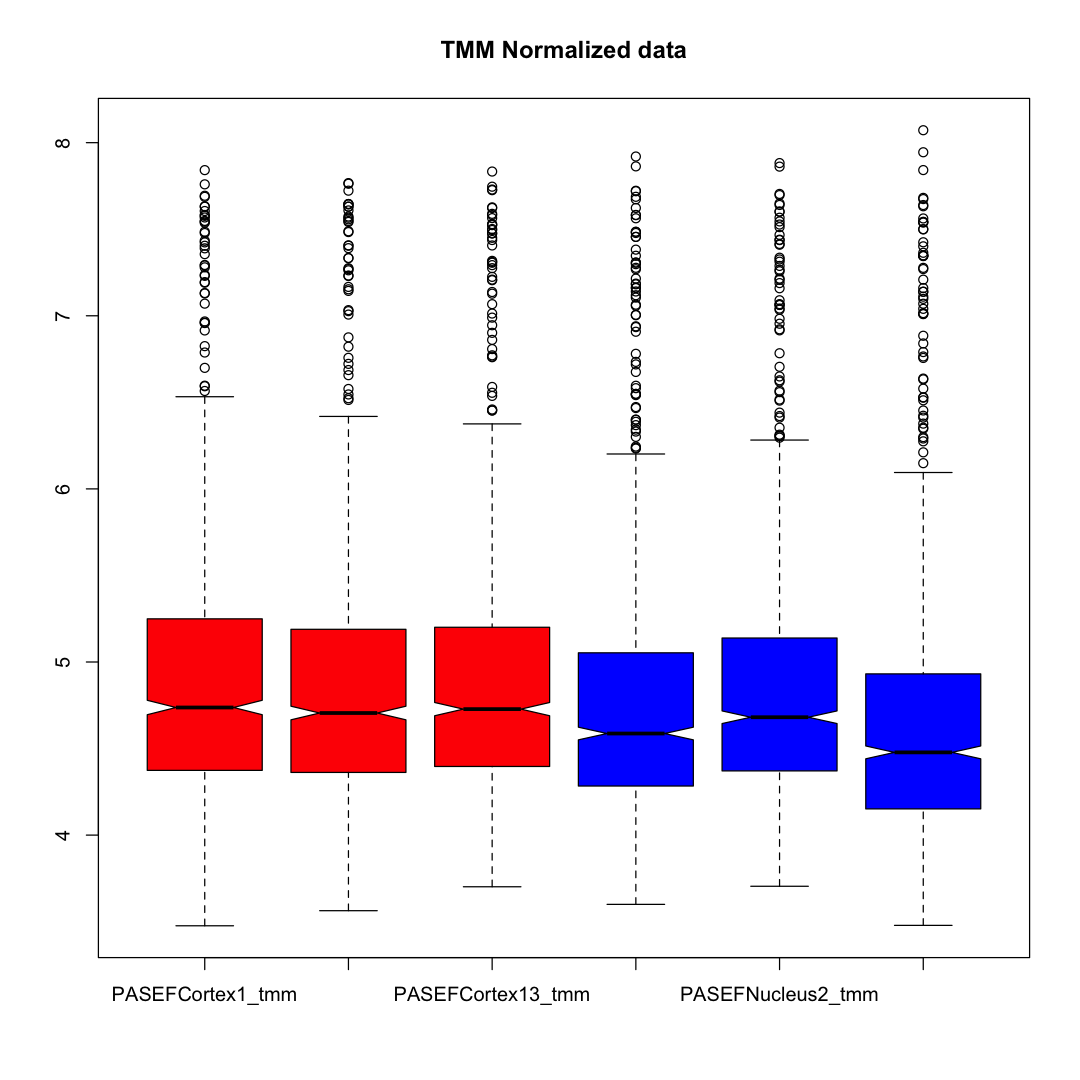

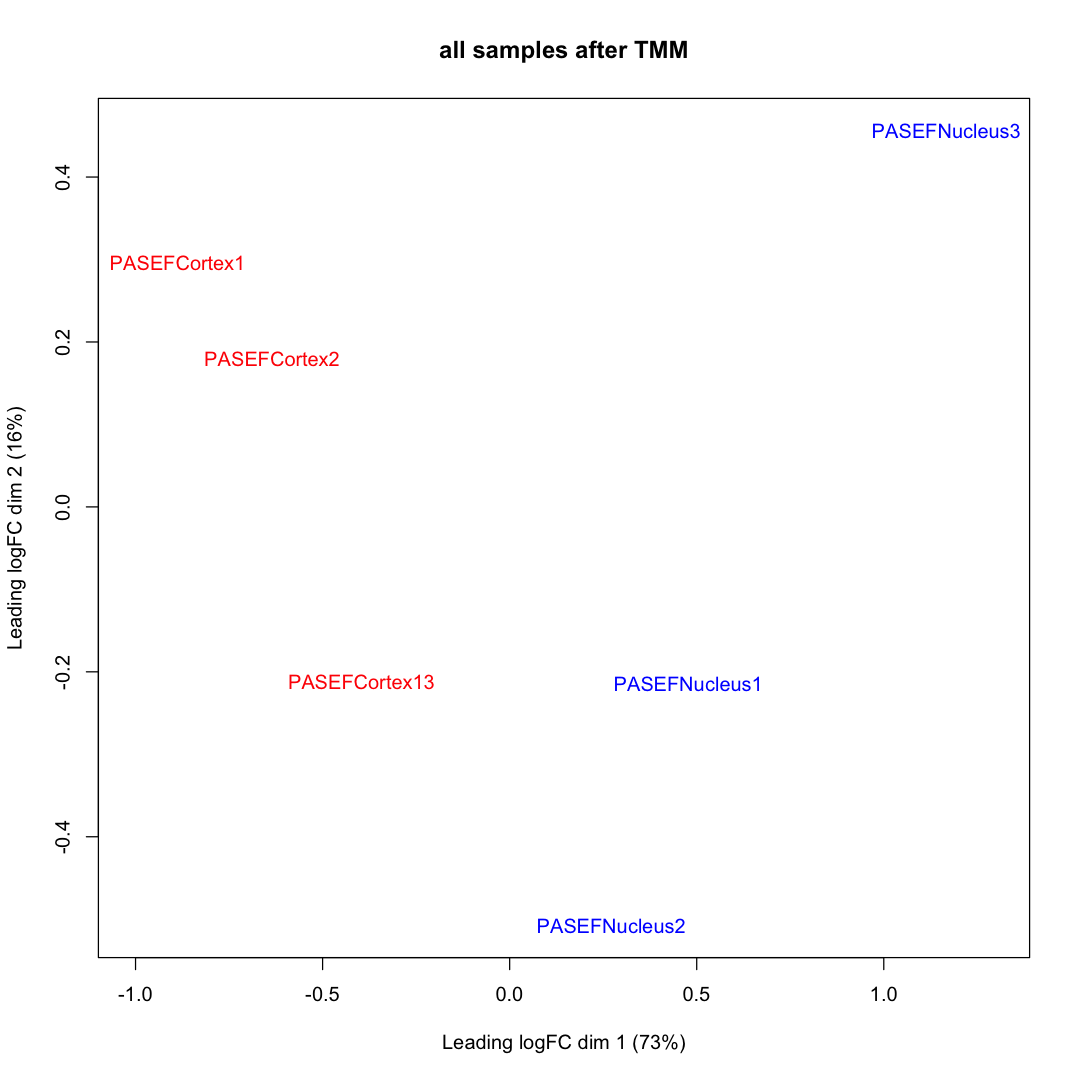

In [5]:
# get the biological sample data into a DGEList object
group = c(rep("cortex", length(cortex)), rep("nucleus", length(nucleus)))

y <- DGEList(counts = dia_data, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
#y <- calcNormFactors(y)

# compute the TMM-normalized intensities
dia_tmm <- apply_tmm_factors(y, color = colors_group)

# check the clustering
plotMDS(y, col = colors_group, main = "all samples after TMM")

### Clustering looks okay

The cortex region samples in red are separated from the nuclear region samples in blue.

## EdgeR statistical testing starts here

### Compute the shared variance trend

One of the more powerful features of edgeR is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for experiments with smaller replicate numbers. We have 6 samples across both conditions to improve the variance estimates and reduce false positive differential expression (DE) candidates. The edgeR `estimateDisp` function does this and provides a visualization function to check the result.

We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take specified conditions and compare them using the normalization factors and dispersion estimates saved in the DGEList object `y`.

Using classic mode.



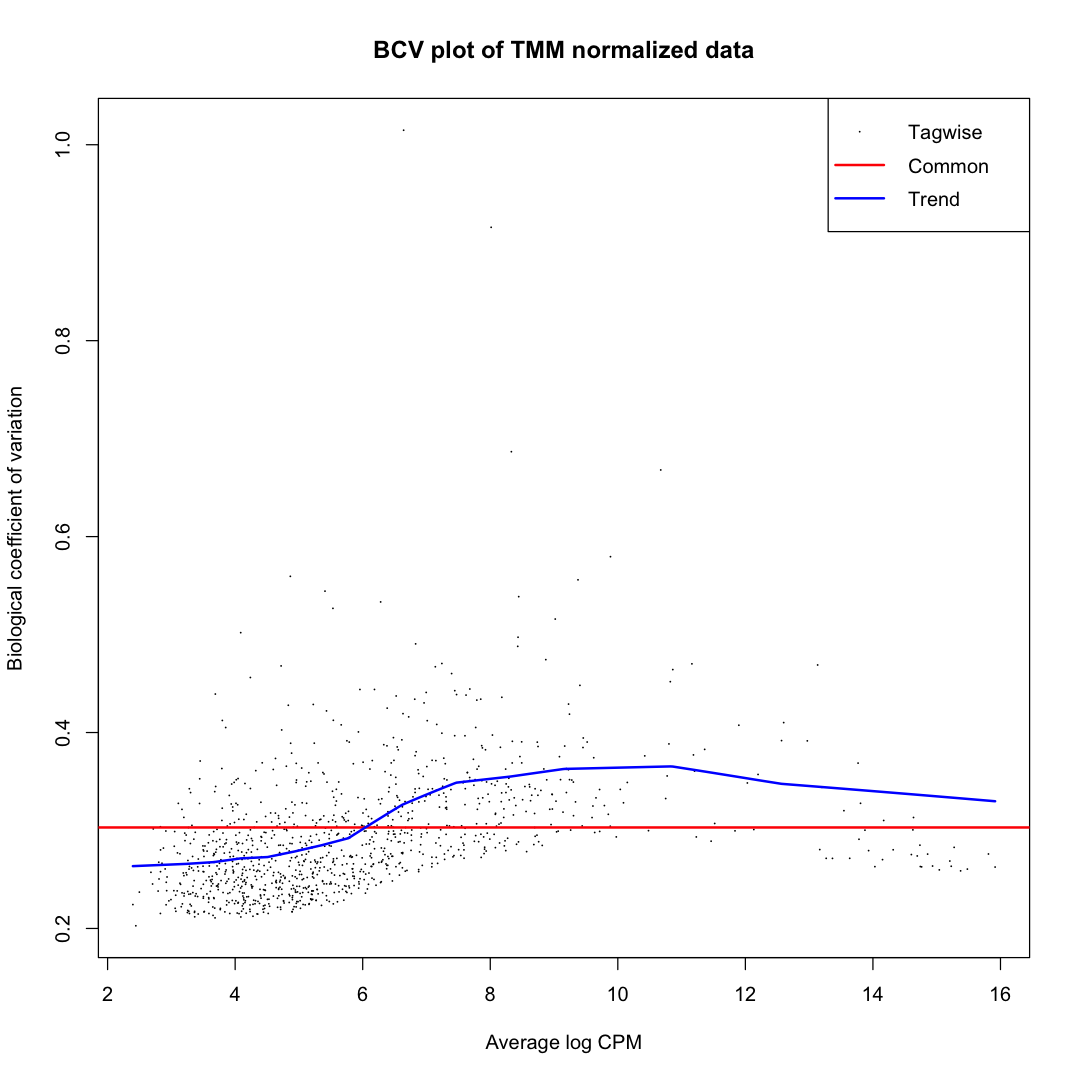

In [6]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of TMM normalized data")

## <a name="CN"></a>Cortex (n=3) versus nucleus (n=3)

Compare cortex region to nucleus region.

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `topTags` table show us the most significant candidates (top 10). We can also summarize how many up and down regulated candidates we have at an FDR of 0.10.  We save the test results in `tt`. We use an MA (mean-average) plotting function from `limma` to visualize the DE candidates and check the p-value distribution.


      genes  logFC logCPM    PValue       FDR
465  E7FET0 -2.266  5.849 1.087e-12 1.199e-09
60   Q6DH12  5.807  9.885 8.093e-12 4.463e-09
89   A7E2K7  4.813  9.019 2.282e-11 6.470e-09
548  Q9DDG2 -2.978  5.440 2.346e-11 6.470e-09
53   Q15I82  6.527 10.673 1.300e-10 2.867e-08
500  Q9W767 -1.898  5.669 2.884e-08 5.301e-06
50   Q4VBU2  3.161 10.823 5.837e-08 8.659e-06
1045 Q7ZW04 -1.455  3.312 6.280e-08 8.659e-06
406  Q6PBZ1 -1.758  6.185 2.833e-07 3.472e-05
51   Q6DGY5  2.471 10.802 3.635e-07 4.009e-05

       nucleus-cortex
Down              485
NotSig            529
Up                 89


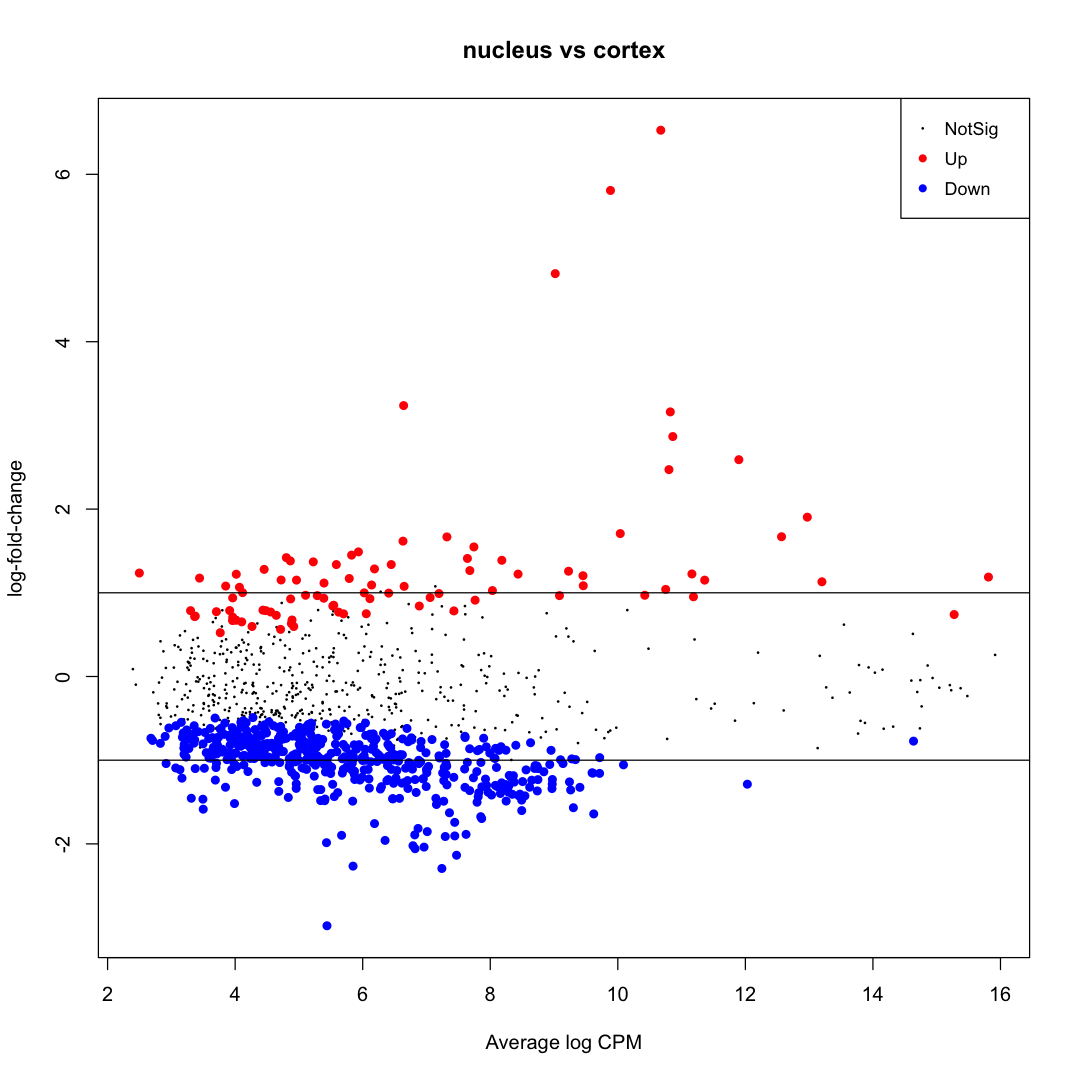

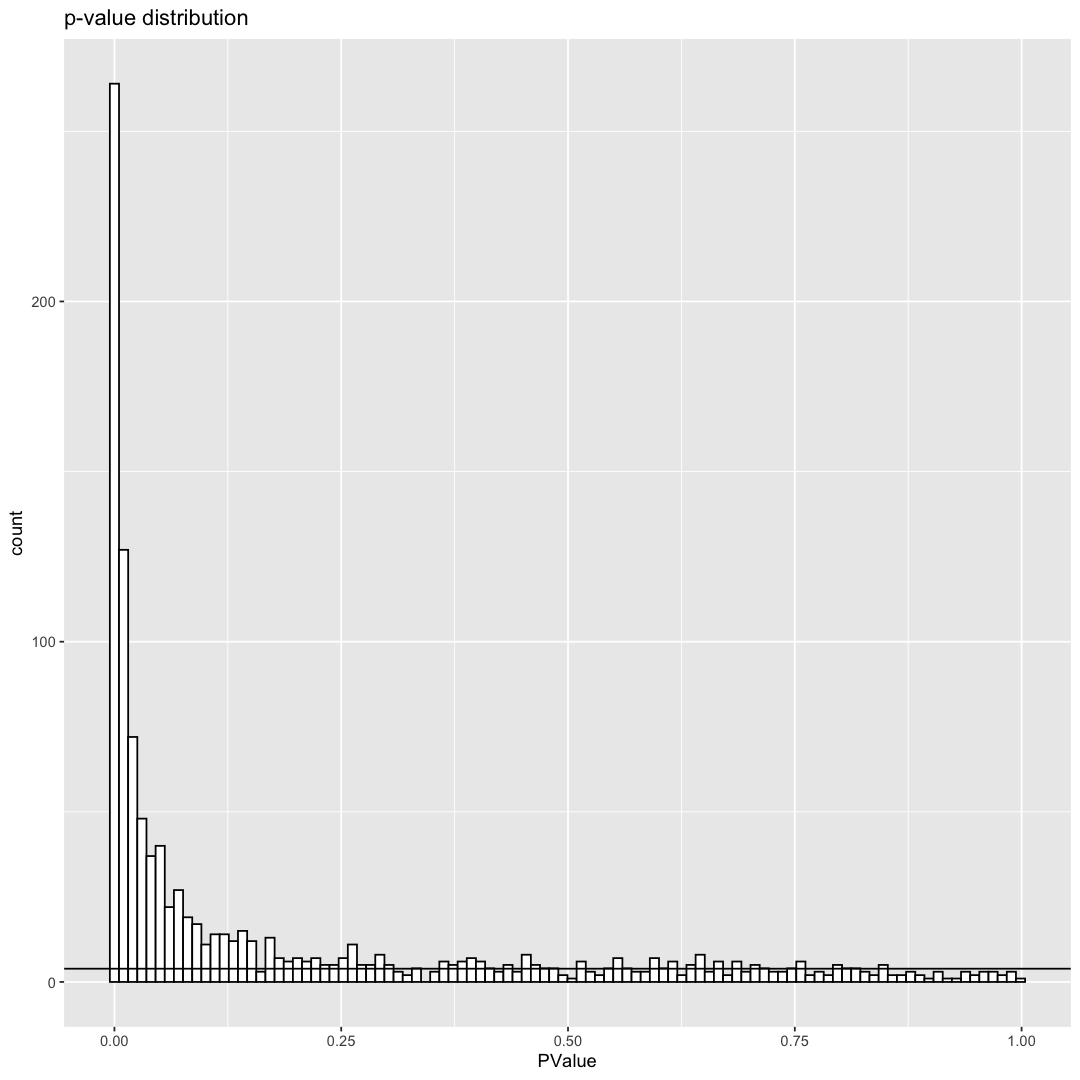

In [7]:
# perform the pairwise test
tt = pairwise_test(y, c("cortex", "nucleus"), 0.10)

### There are 574 DE candidates

Candidates are strongly biased towards the Down direction (485 Down candidates to 89 Up candidates), although Down candidate intensities tend to be lower. The p-values form two distributions: a flat distribution from 0 to 1 from unchanged proteins and a sharp spike at small p-values from the DE candidates. 

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and accumulate all comparisons into `all_results`.

We will make MA plots, scatter plots, and a volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [8]:
# get the results summary
results <- collect_results(dia_tmm, tt$table, cortex, "cortex", nucleus, "nucleus")

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_CN")

# accumulate testing results
all_results <- cbind(accessions, results_temp)

### Count candidates and look at fold-change distributions


  candidate   n
1      high 131
2       med 291
3       low 152
4        no 529



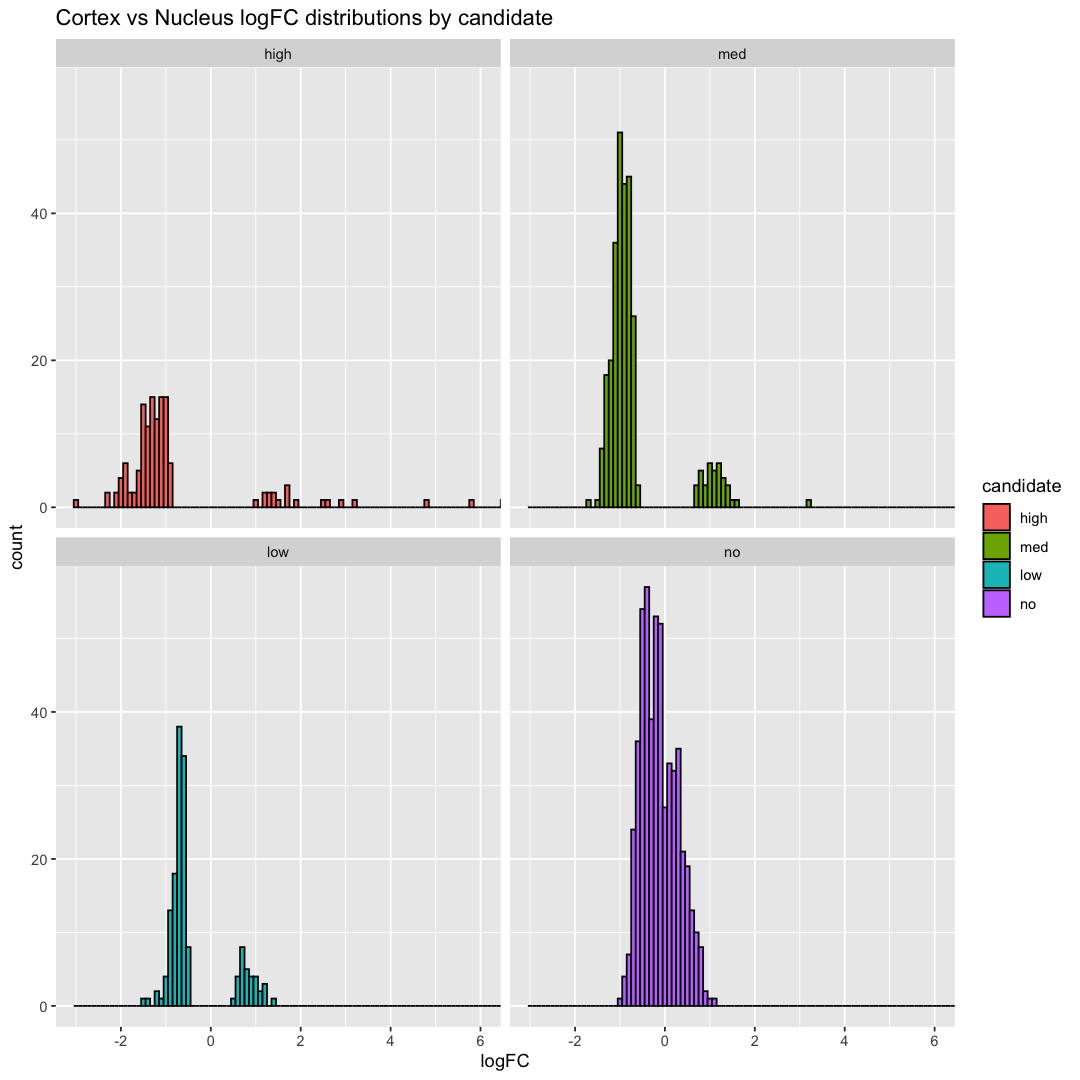

In [9]:
# count candidates and check log2 fold change distributions
log2_fold_changes(results, 3, 6, "Cortex vs Nucleus logFC distributions by candidate")

### Distribution of fold changes for unchanged proteins is broad

The purple distribution (unchanged proteins) of fold changes is broad. 

## Main summary plots

We will make an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

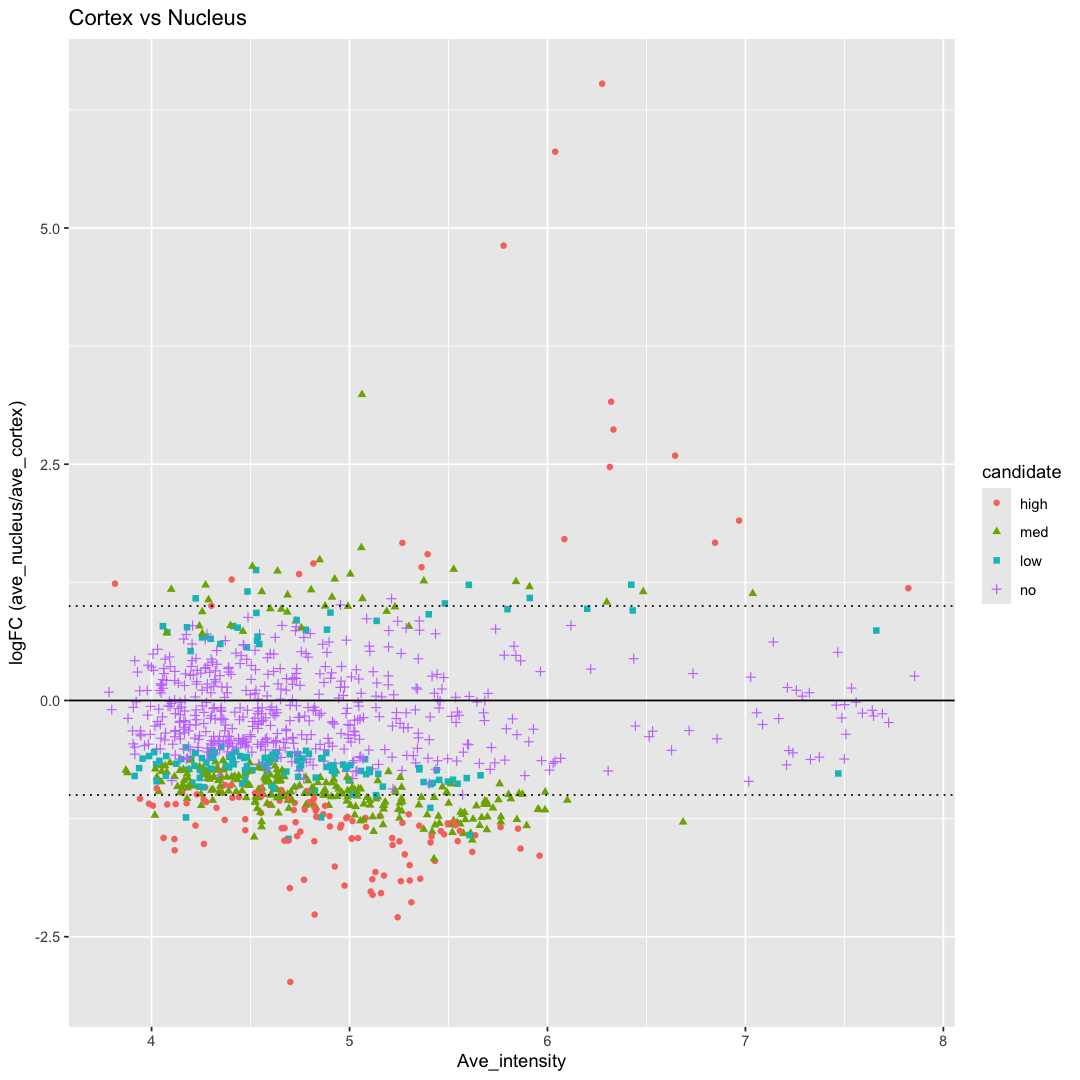

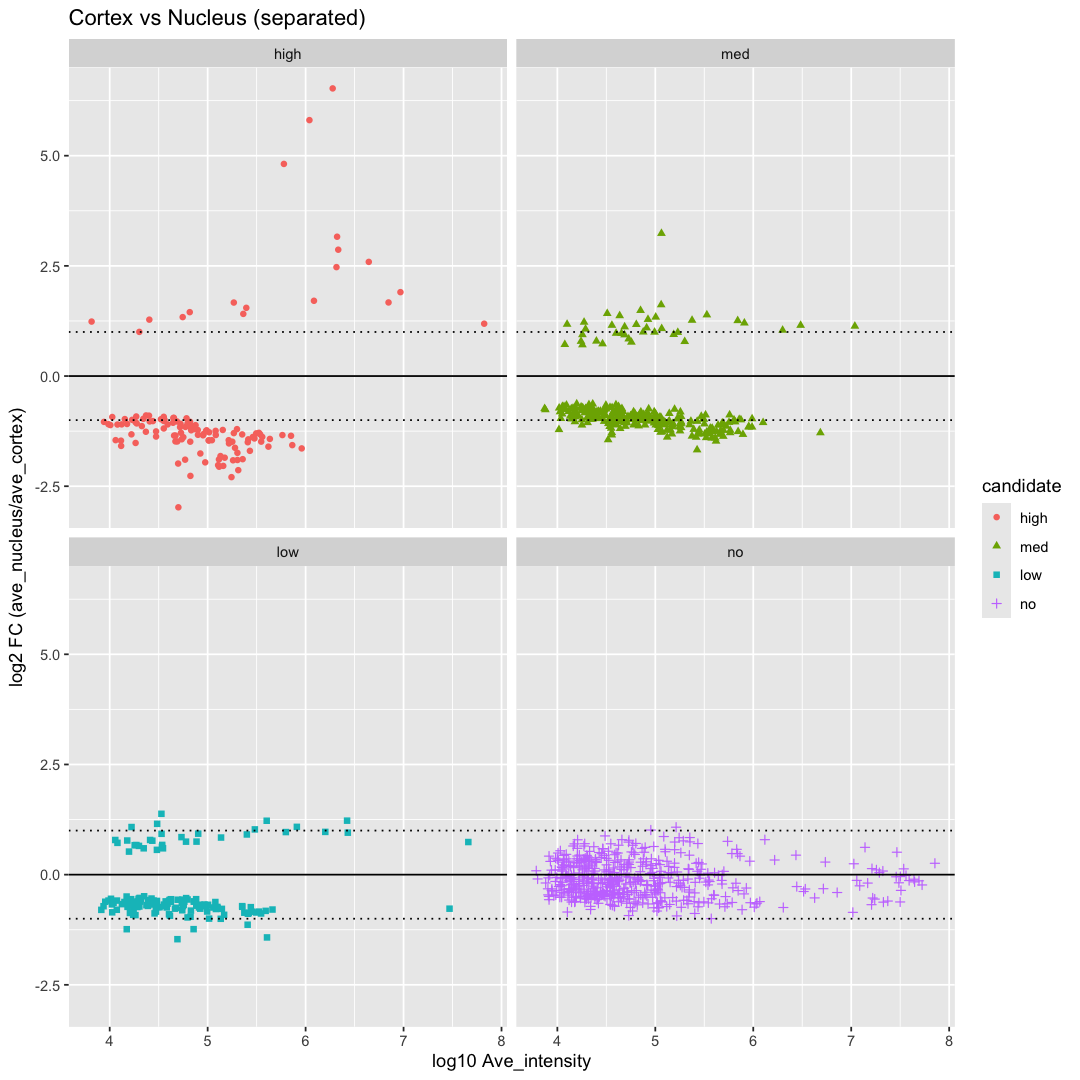

In [10]:
# make MA plots
MA_plots(results, "ave_cortex", "ave_nucleus", "Cortex vs Nucleus")

#### Faceted MA plots are pretty ugly

High abundance not significant proteins have excessive scatter. In DDA proteomics methods, the high abundance to mid abundance proteins seem to be a larger fraction of the quantifiable proteins and seem to be better behaved (more consistent measurements and tighter distributions of fold changes closer to zero for non-significant proteins). This DIA data seems to be dominated by noisy low abundance proteins and even the high abundance proteins seem very noisy. I am not seeing anything that makes me want to switch to DIA. 

### Scatter plots

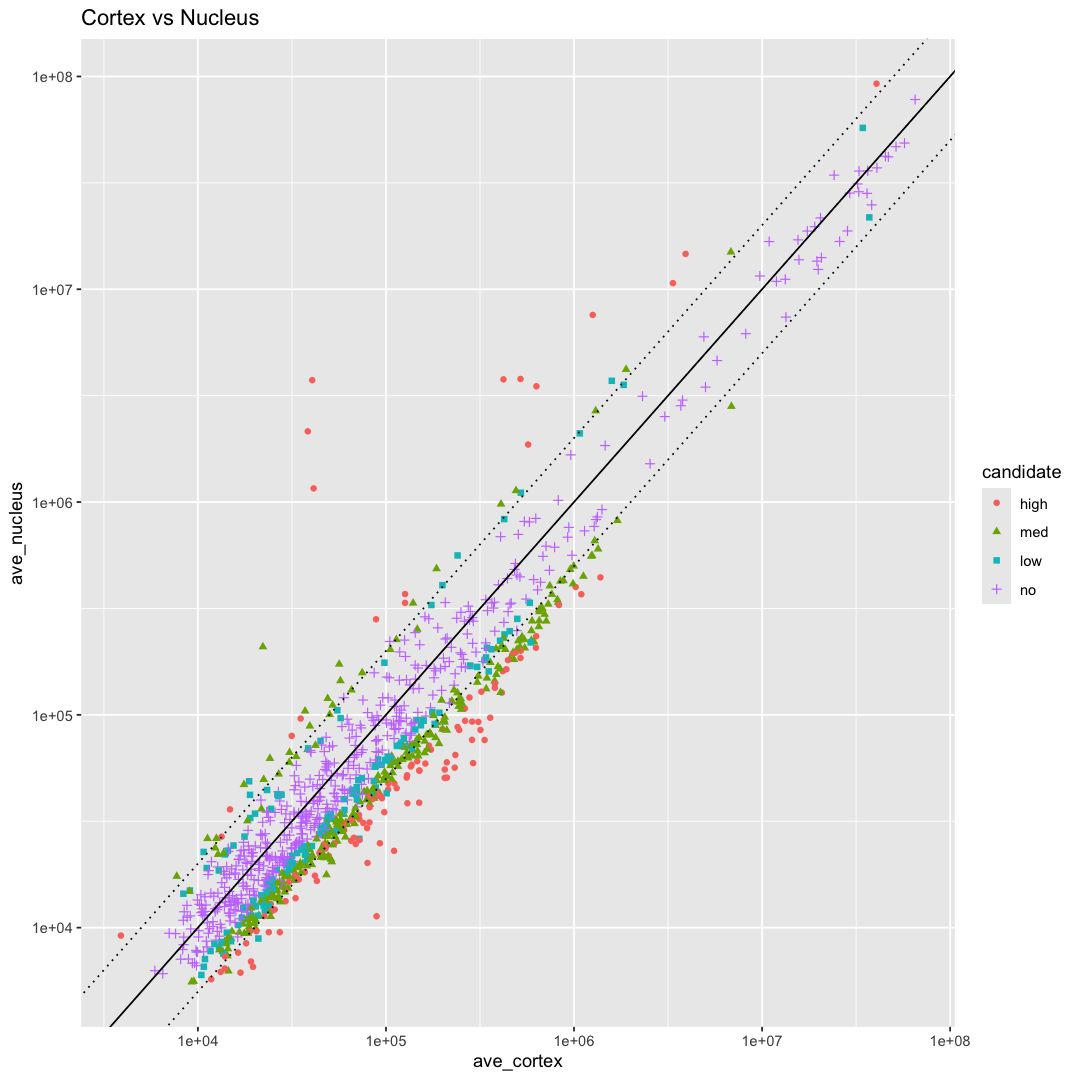

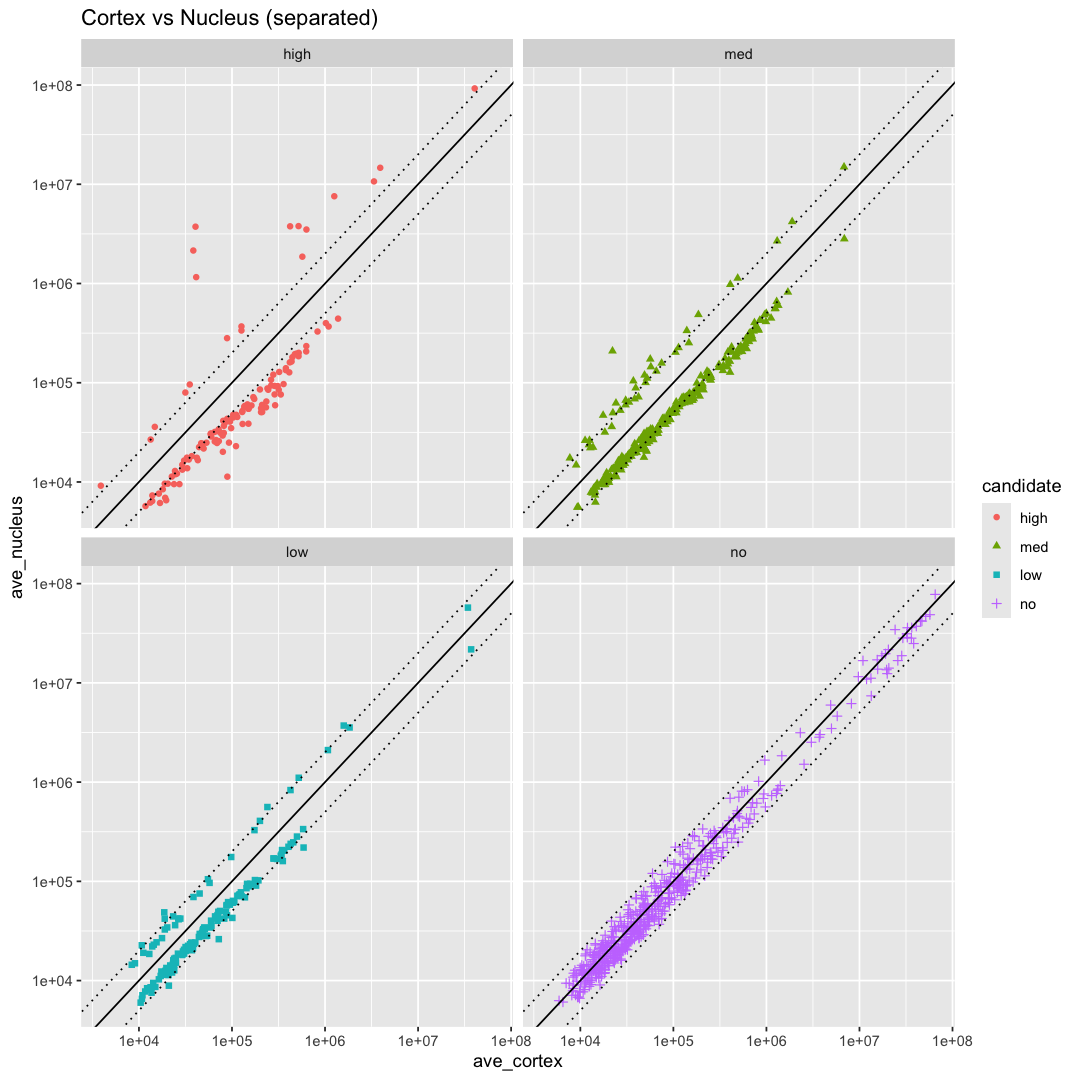

In [11]:
# make scatter plots
scatter_plots(results,  "ave_cortex", "ave_nucleus", "Cortex vs Nucleus")

#### Bimodal intensity distributions?

It looks like there are two distributions of intensities. One is for high abundance proteins (the upper two decades) and the other is for low abundance proteins (the bottom two decades) with centers of distributions separated by about 2 decades. That is not a pattern I have seen in other spectral counting or TMT labeling lens studies. Given that major lens proteins are highly over-expressed, such a pattern may seem plausible. I think that conclusion would be premature without more exploration of DIA data for other systems where some prior knowledge of proteome characteristics are known. It is important to use less biased QC metrics for DIA that are well established for other quantitative methods. Spike-in standards are woefully inadequate for testing methods.

### Volcano plot

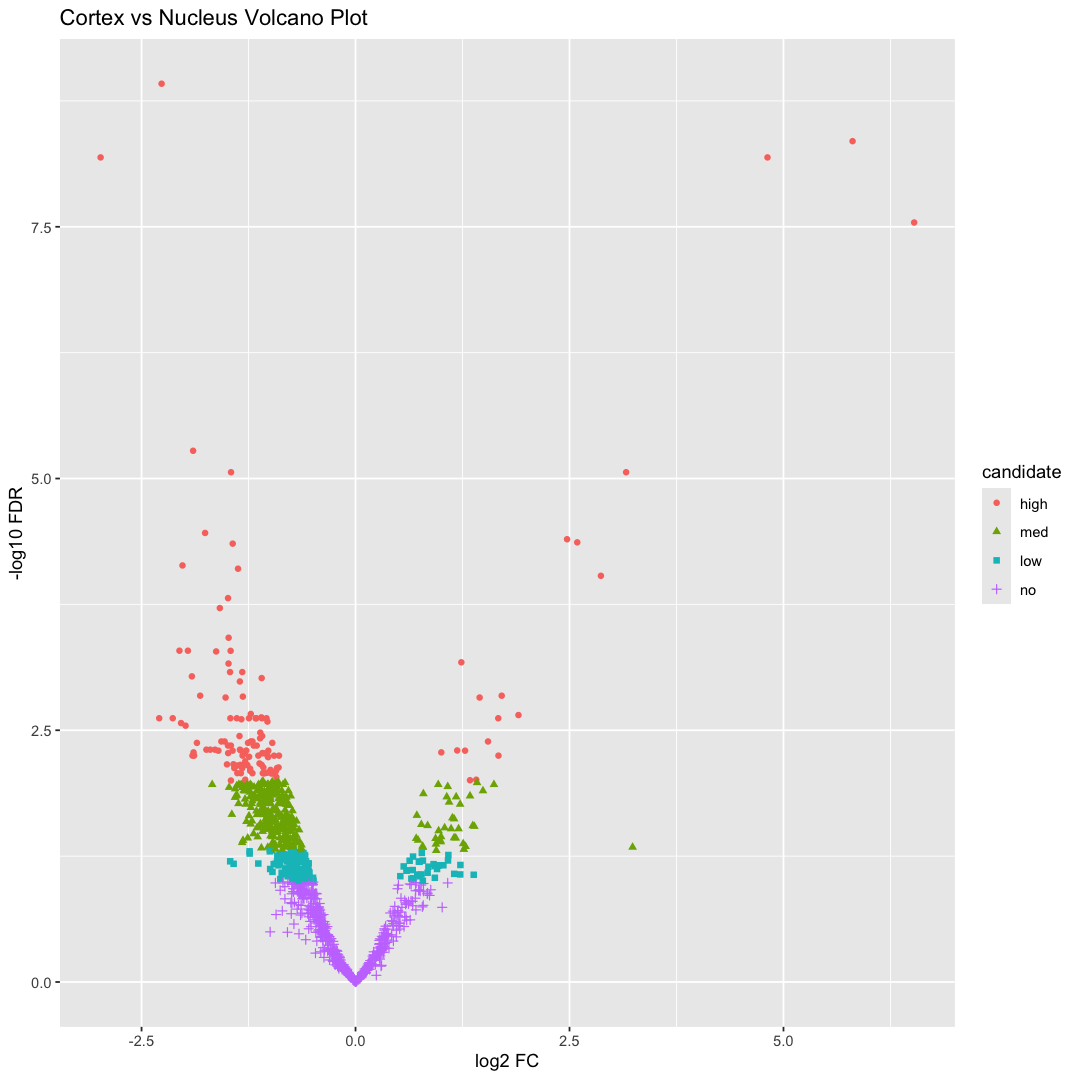

In [12]:
# make a volcano plot
volcano_plot(results,  "ave_cortex", "ave_nucleus", "Cortex vs Nucleus")

### Check some individual proteins

We will look at the individual protein abundance levels for the top 20 up and down DE candidates based on adjusted p-values.

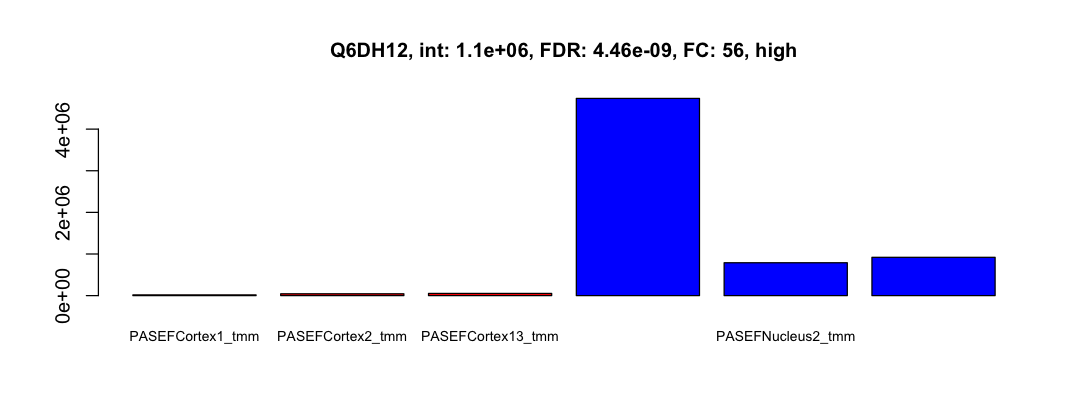

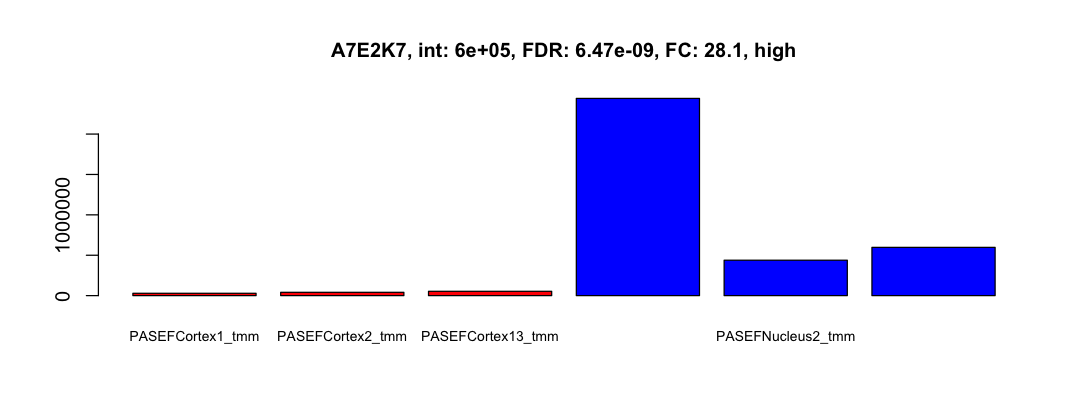

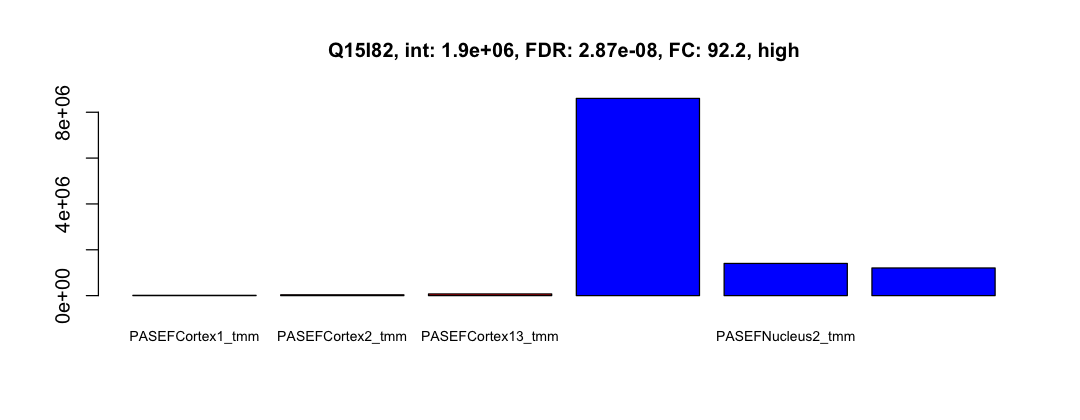

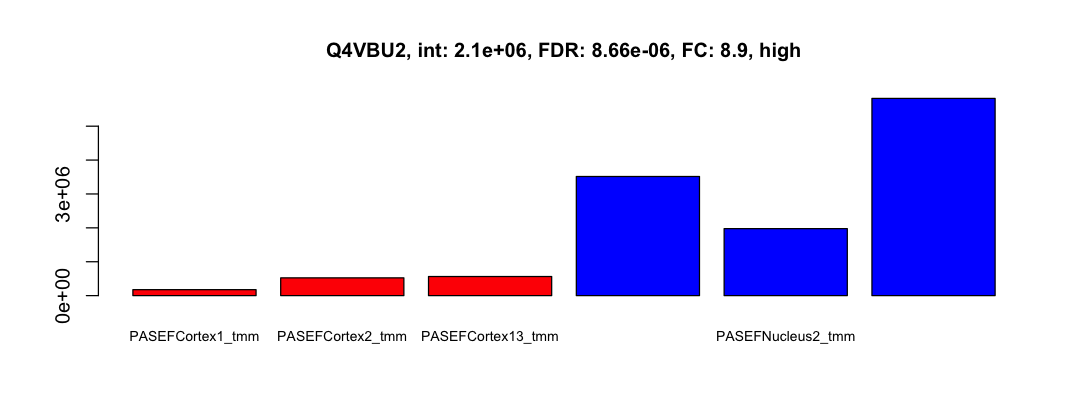

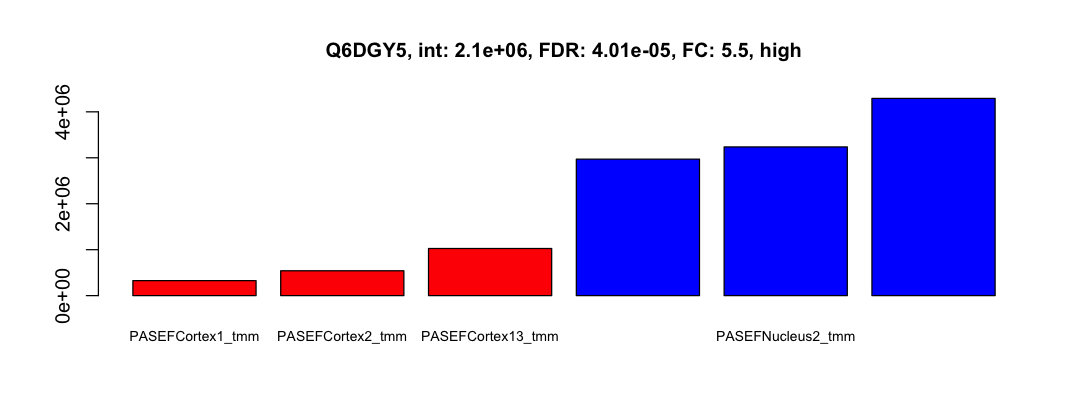

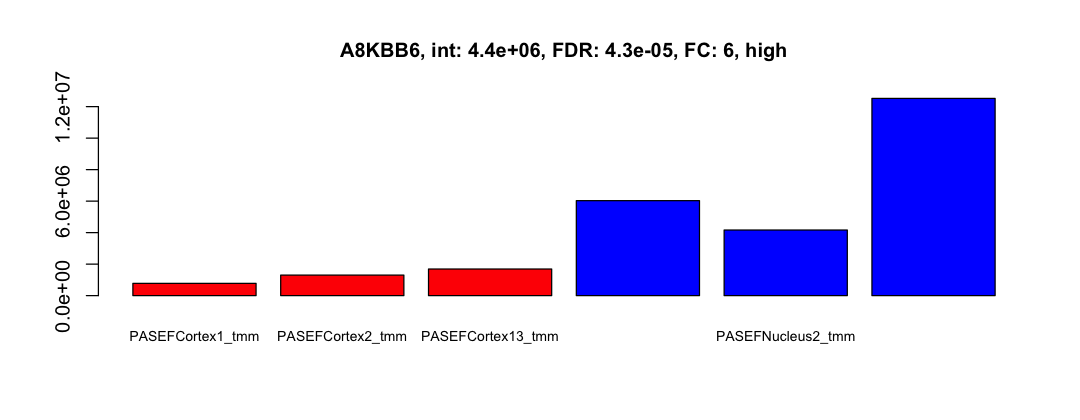

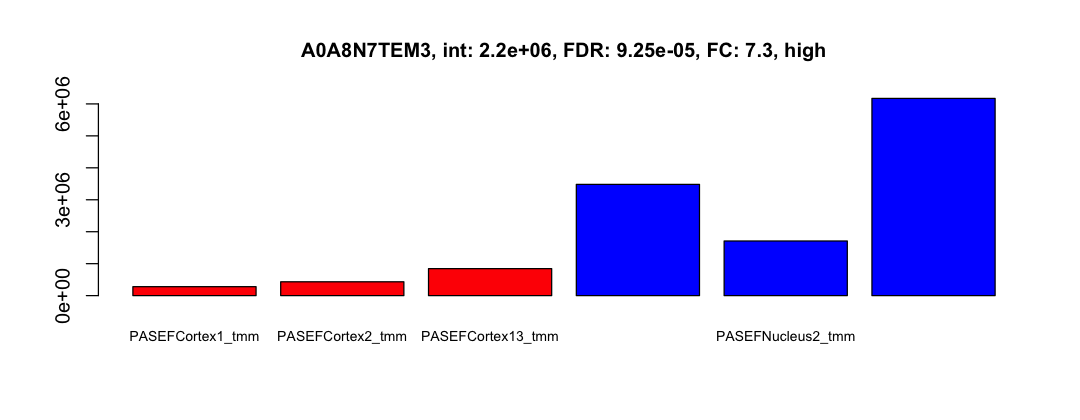

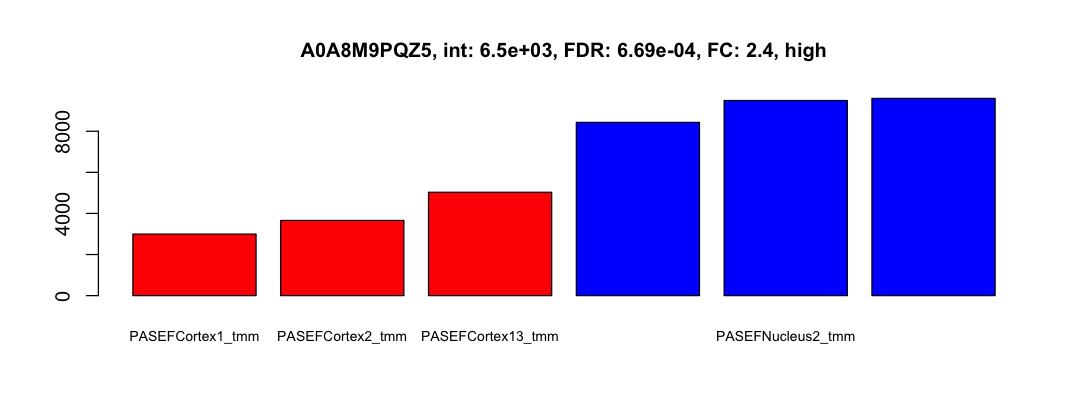

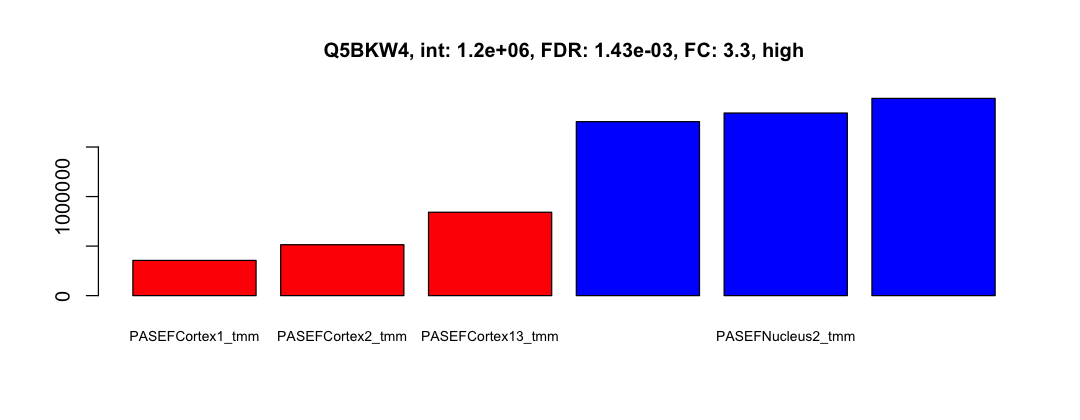

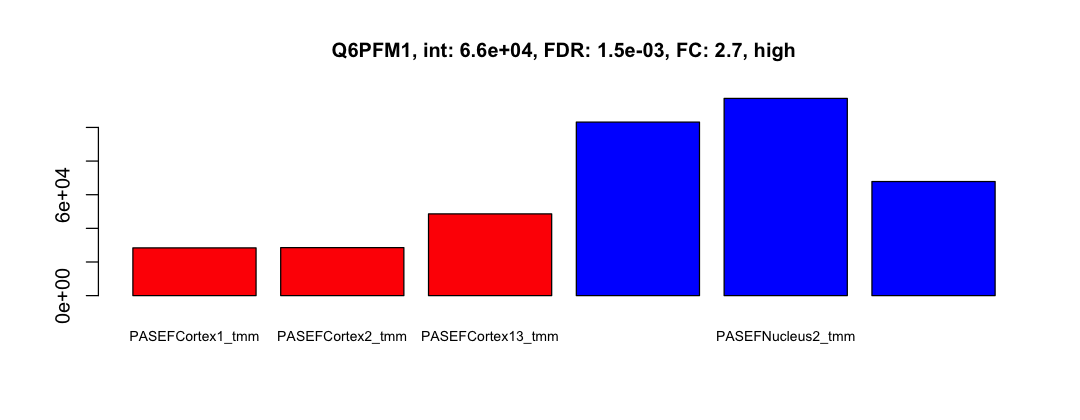

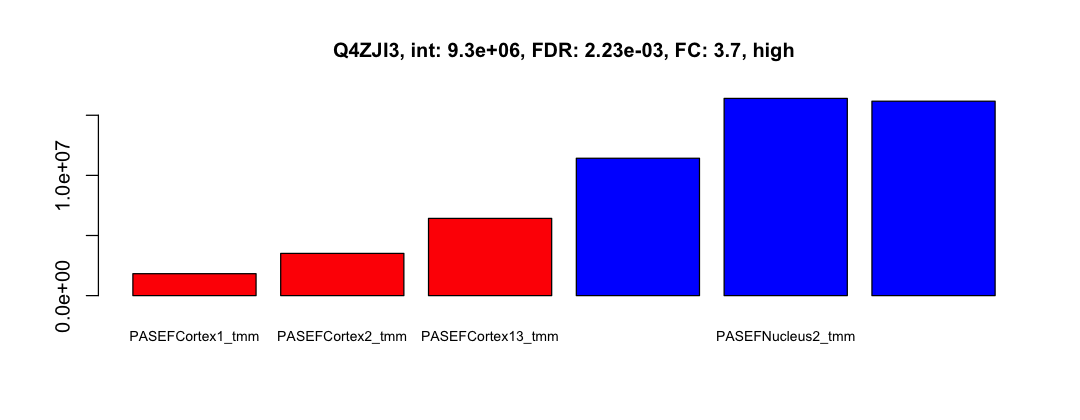

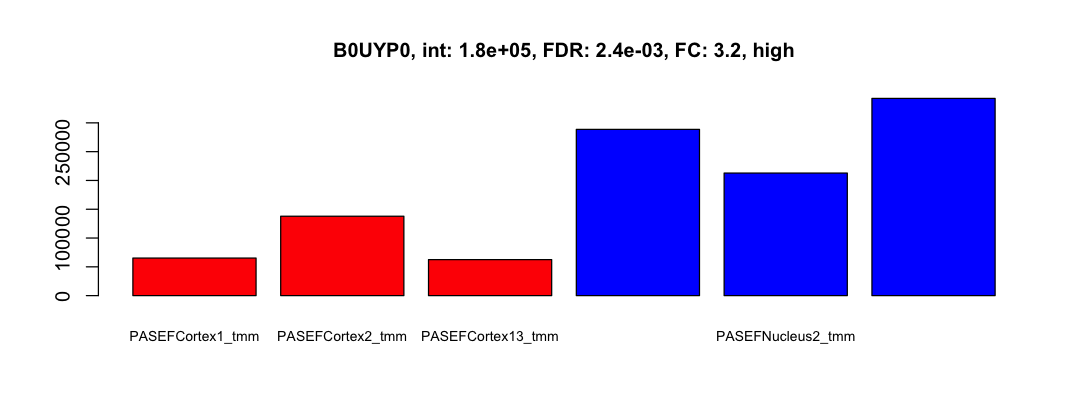

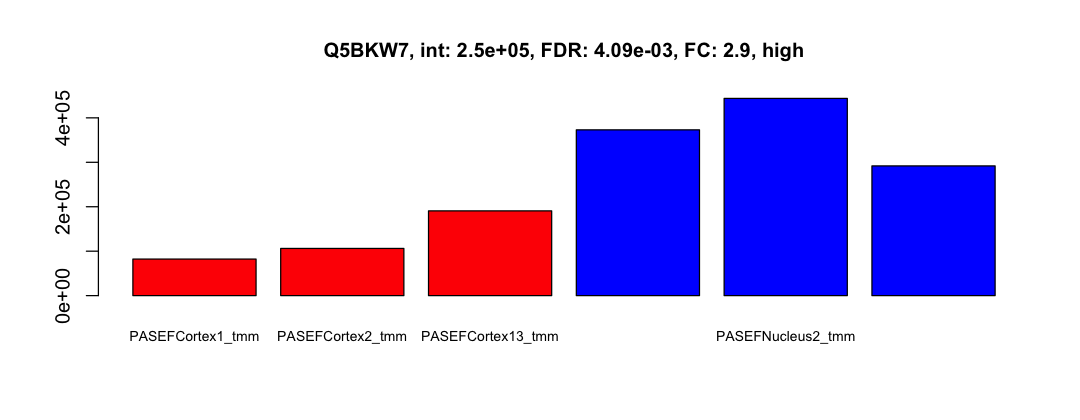

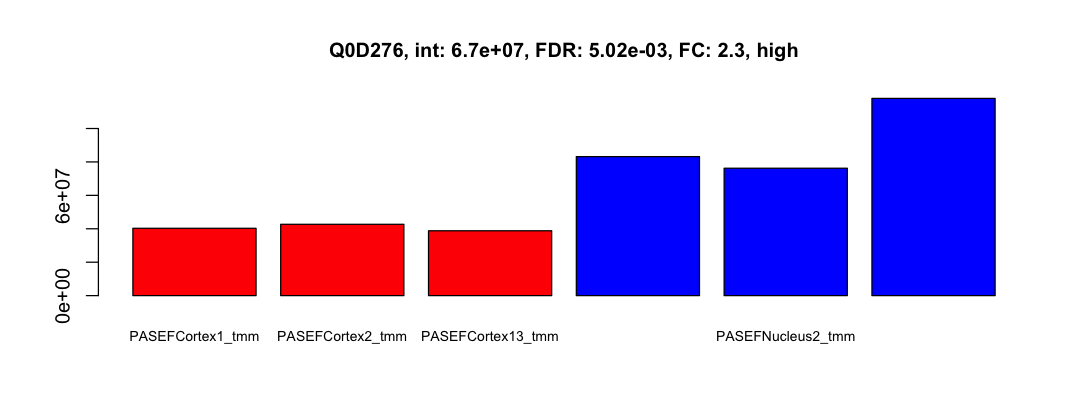

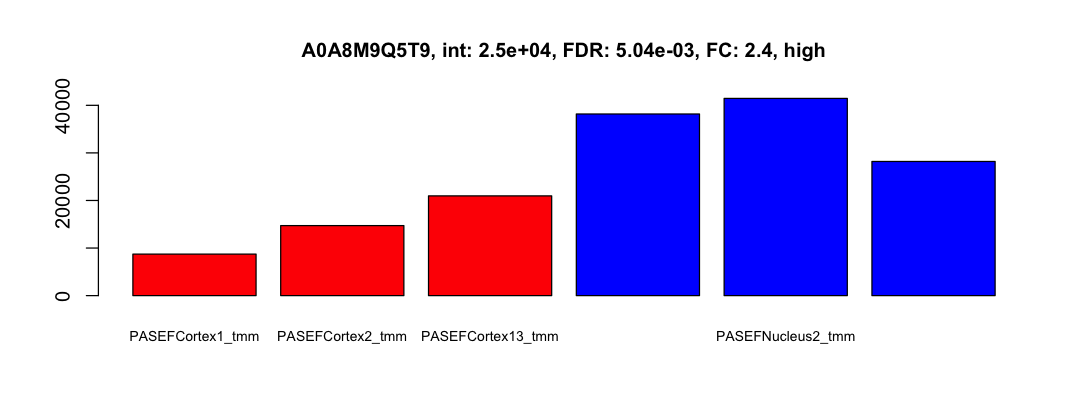

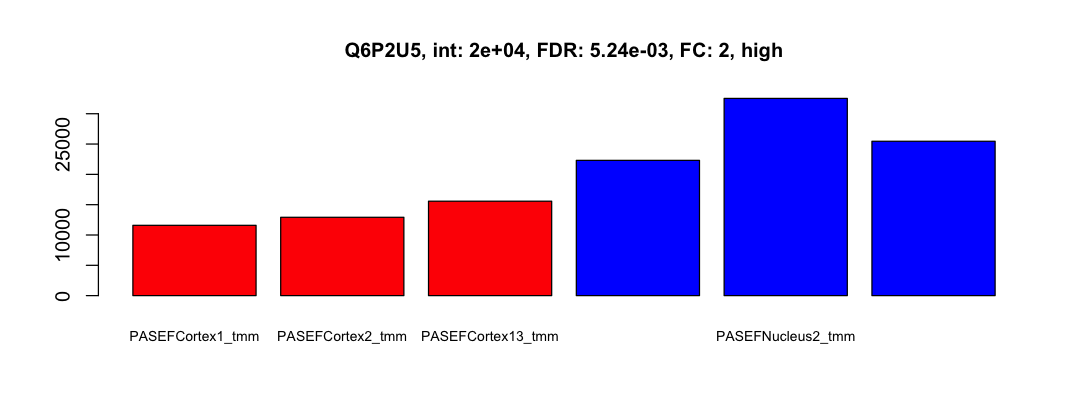

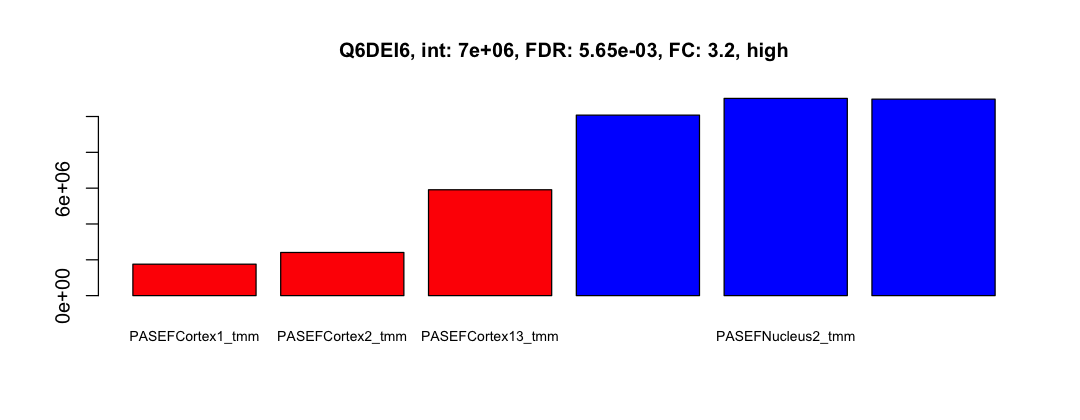

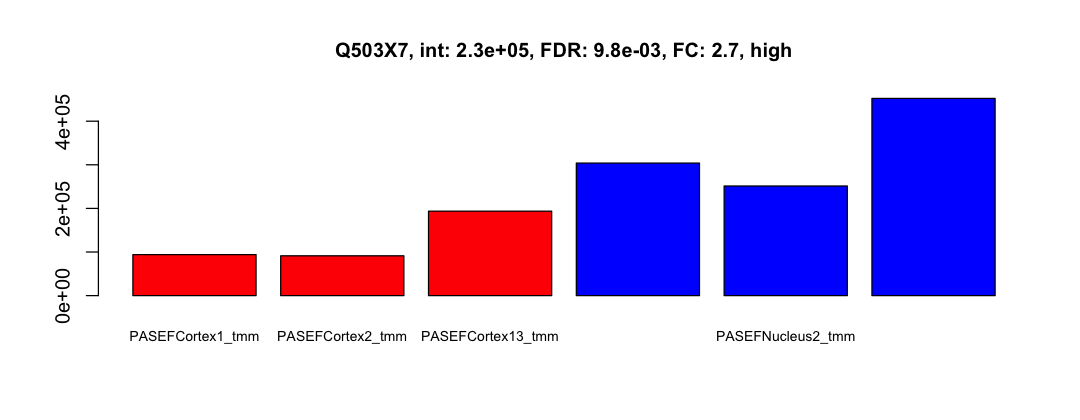

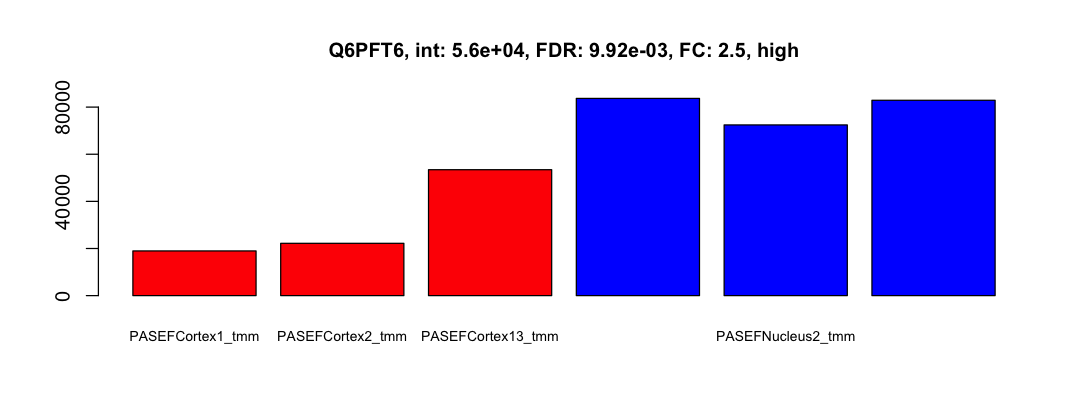

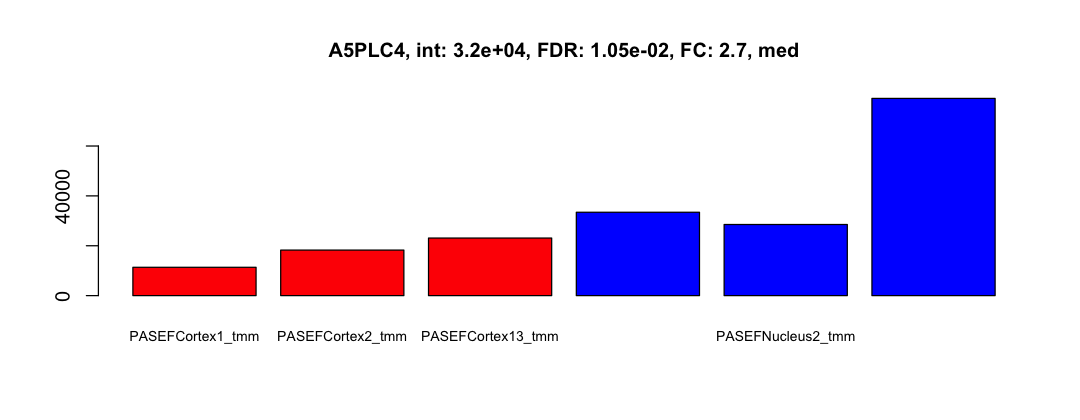

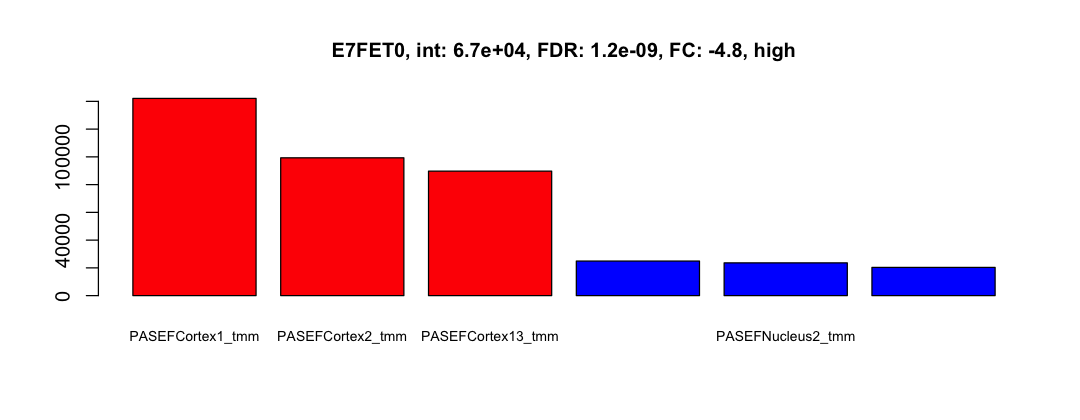

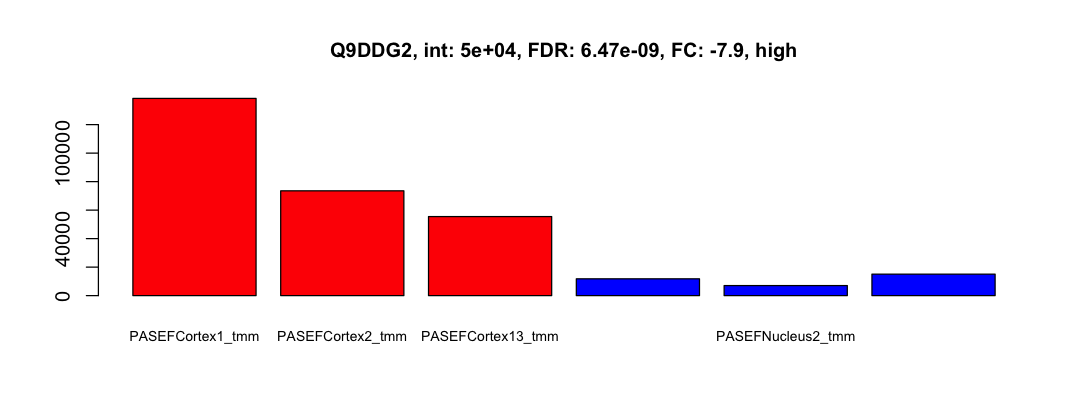

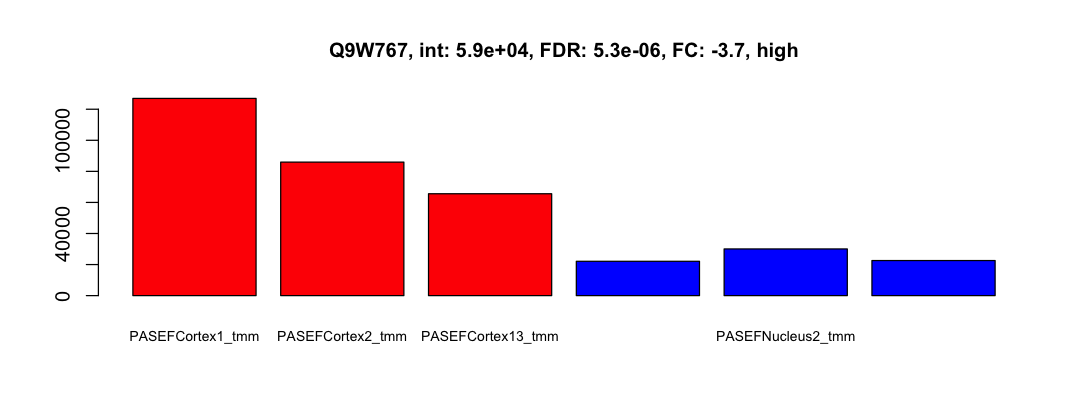

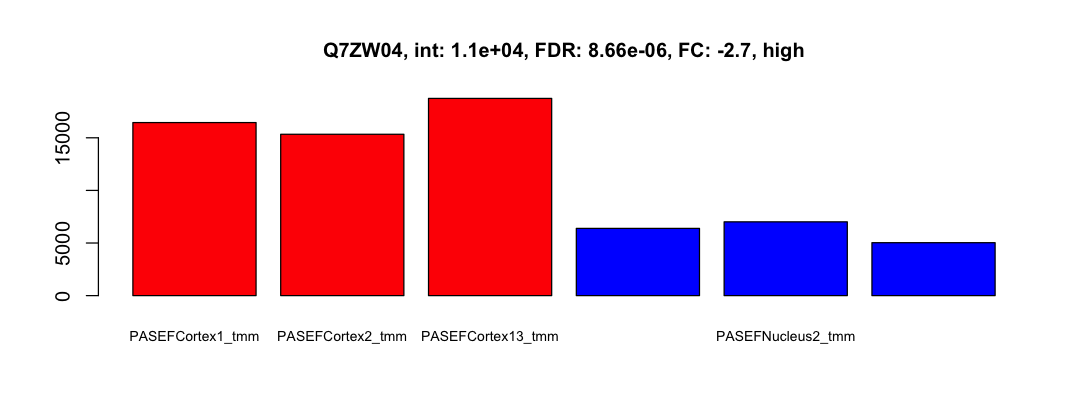

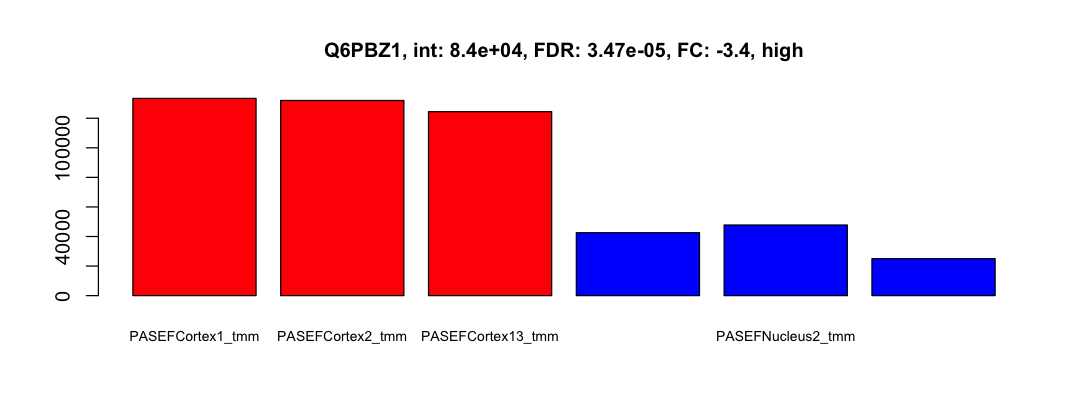

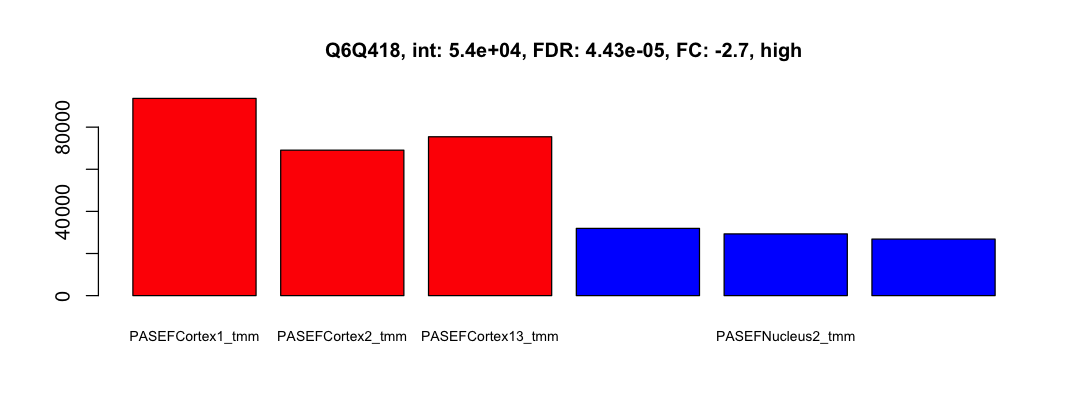

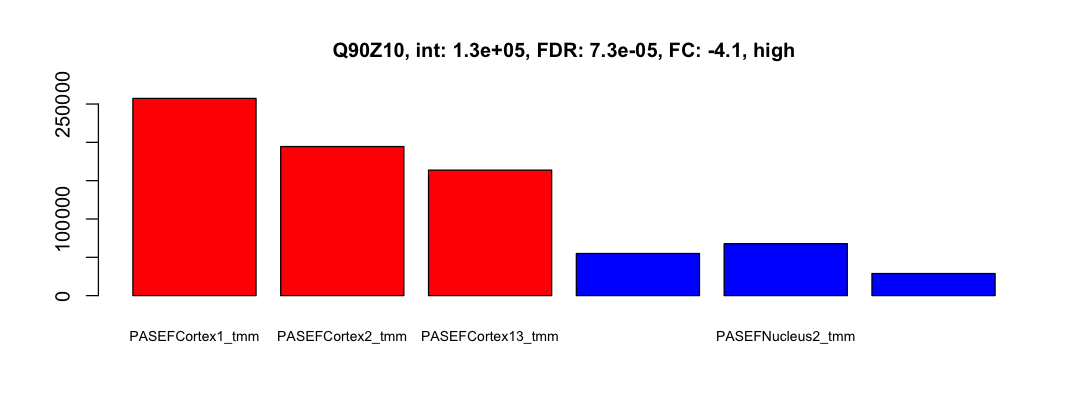

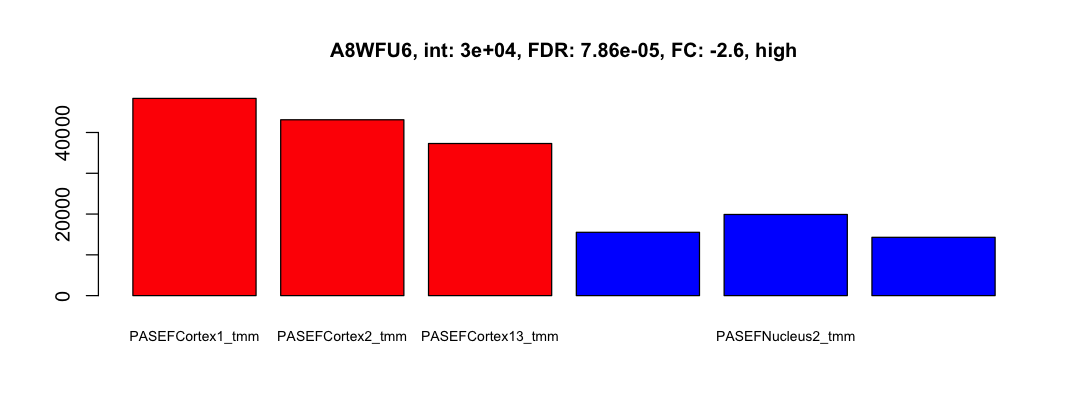

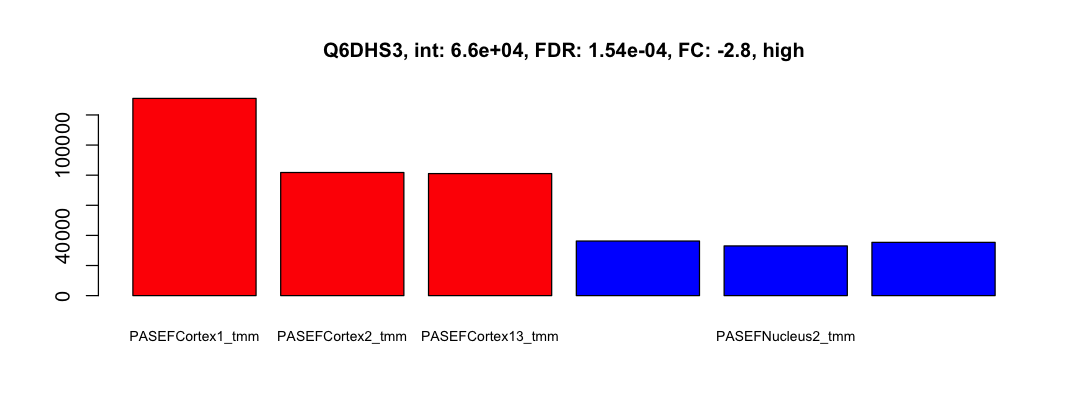

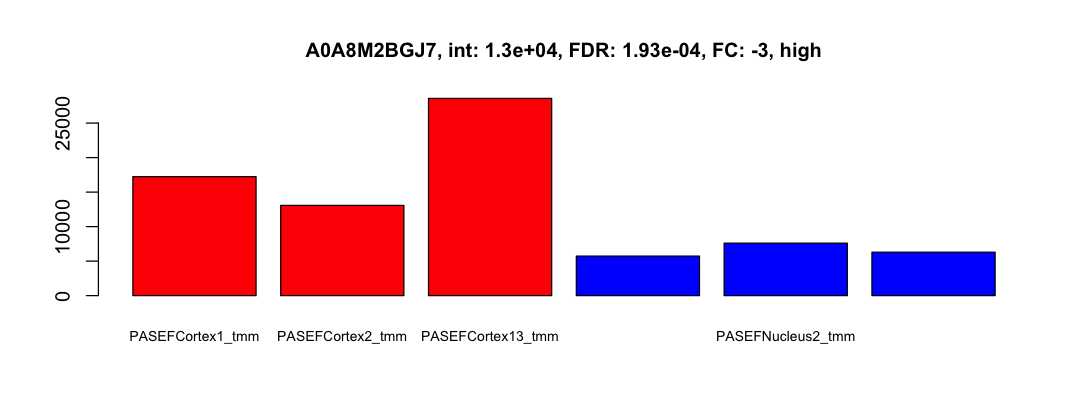

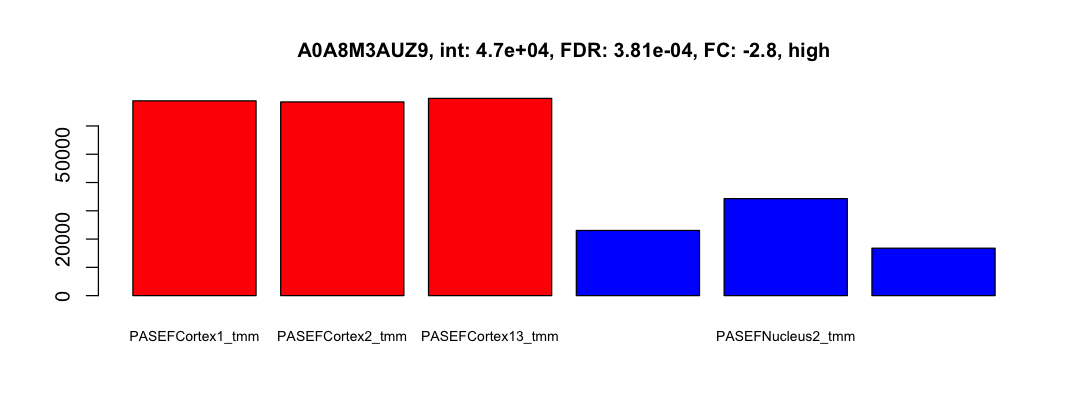

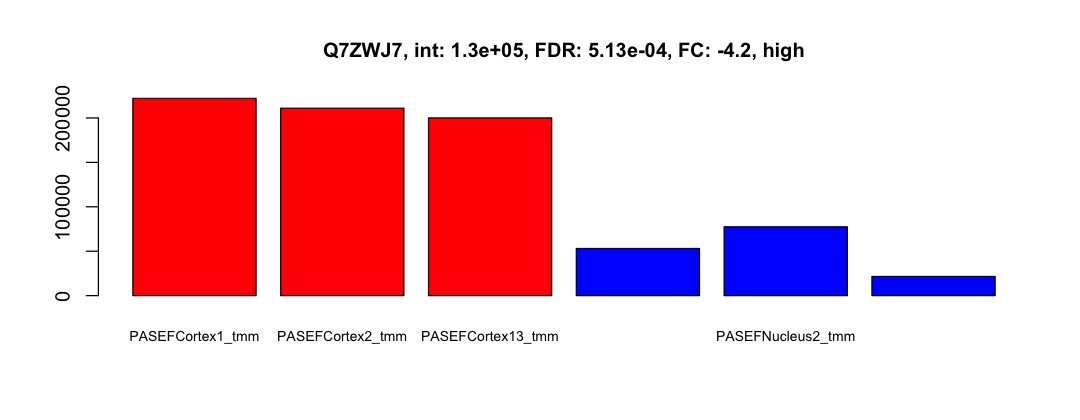

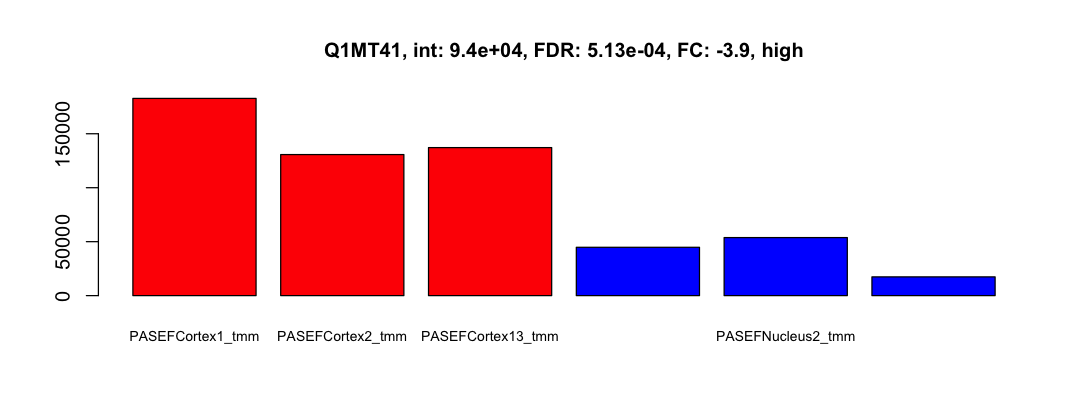

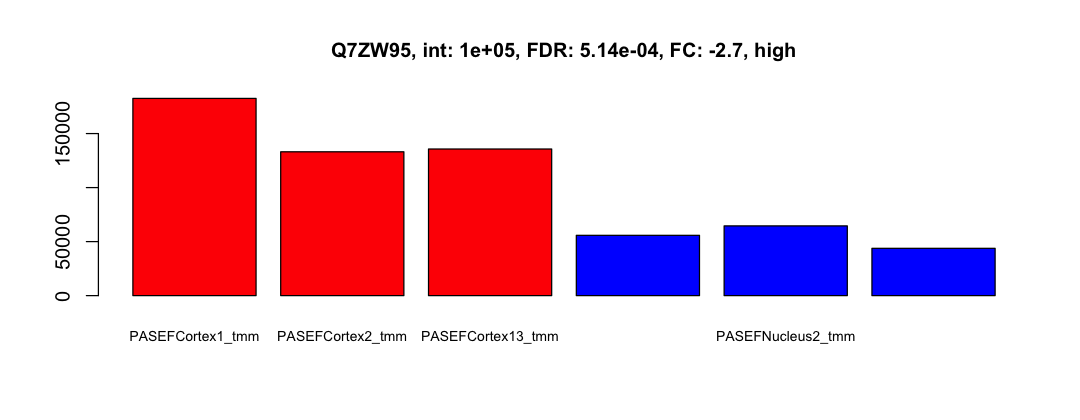

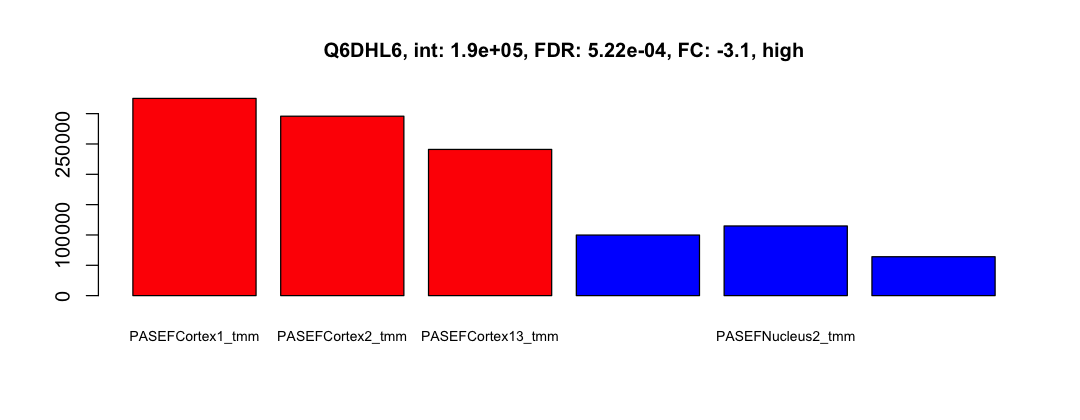

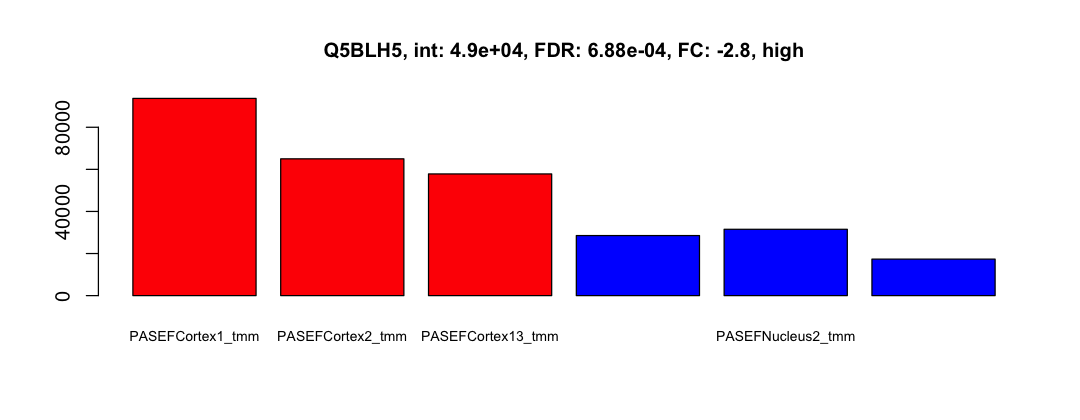

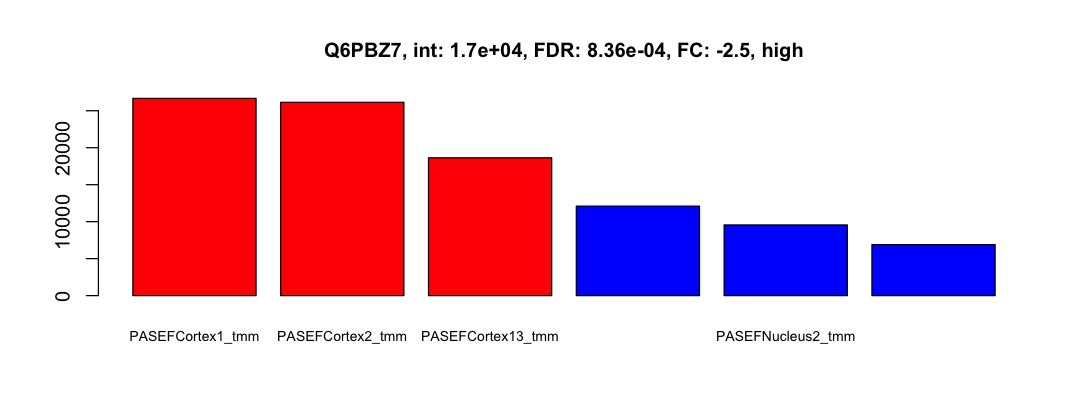

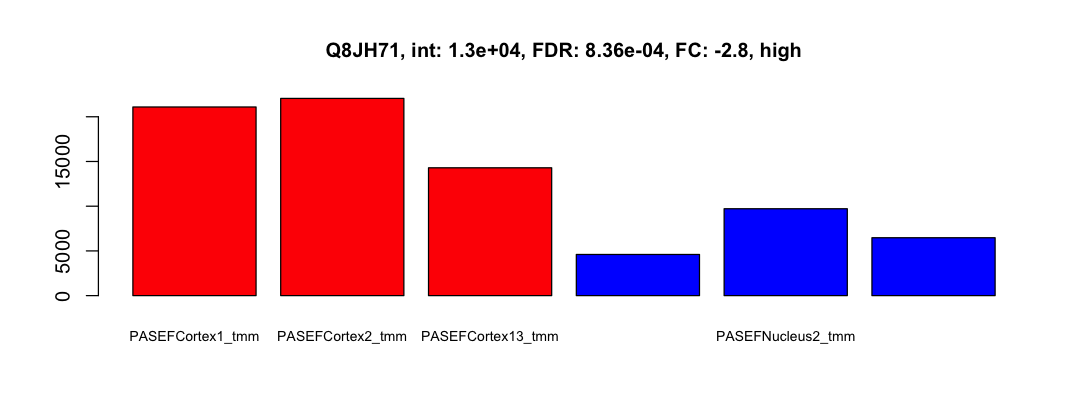

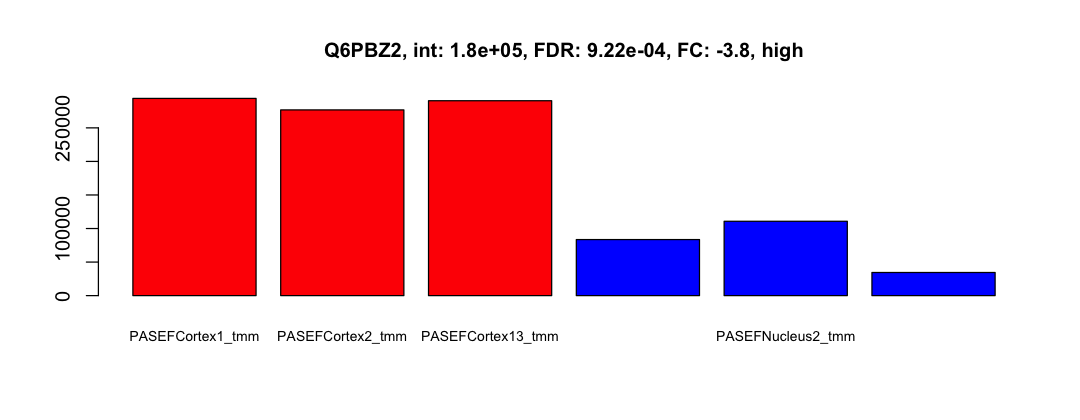

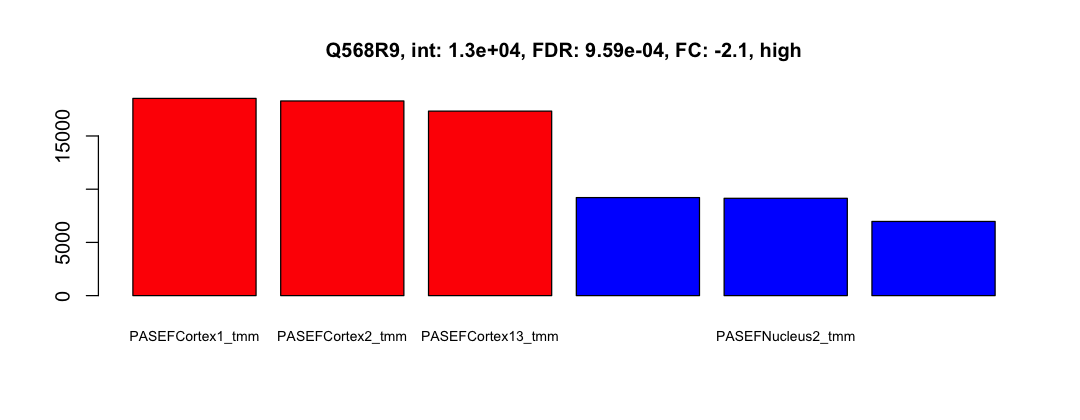

In [13]:
# adjust plot size to save vertical space
set_plot_dimensions(9, 3.5)

# look at the top candidates
n_left <- length(cortex)
n_right <- length(nucleus)
top_tags <- 20
color <- c("red", "blue") 

plot_top_tags(results, n_left, n_right, top_tags, color)

# set the plot size back to normal
set_plot_dimensions(9, 9)

### Individual candidates have a lot of variability

Some of the fold changes (especially positive values) are very large, almost too large to seem biologically plausible. Proteins are labeled by accessions, so it is hard to know what these proteins are. Things will be explored more in the Excel results sheets.

## <a name="summary"></a> Summary

The data is quite ragged looking. DIA is sold as not having the variability that everyone blames on DDA methods, but this data looks more variable than data from other quantitative methods. This data is not very impressive compared to TMT data and seems on par with spectral counting. The Bruker platform seems to produce more noisy low abundance proteins in the results table. It could be that TOF analyzers are inherently nosier than Orbitrap analyzers and that extracted ion chromatograms of noise dominate the results.

There are probably two factors at play. I think the FDR for protein IDs, especially for low abundance proteins is poorly estimated for DIA data. I suspect many IDs are not correct. The other issues are noisy XICs and XICs of noise (two related but not synonymous issues). The data for unchanged proteins is all over the map. Modern instruments should be able to measure the same thing reliably, not within a factor of 2, particularly when pseudo random data acquisition factors (DDA) have been (supposedly) eliminated with DIA.

DIA quantification is probably better than nothing, but far from any sort of "gold standard".

## Save the `all_results` frame to TSV file

We collected the normalized data and statistical testing results from the comparison and will save that table to make a spreadsheet summary.

In [14]:
write.table(all_results, "Schey_results_edgeR-exact_PASEF_noTMM.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [15]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-apple-darwin20
Running under: macOS 15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.4.3     edgeR_4.2.0     limma_3.60.2    scales_1.3.0   
 [5] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [9] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
[13] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    stringi_1.8.4     lattice_0.22-6   
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3    